In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch
from torch.utils.data import TensorDataset
import cmath
from run_VAE import sites_NOVEMBER, RAW_NOVEMBER, INTERMEDIATE_NOVEMBER
from HiddenStateExtractor.cv2_feature import get_density, get_angle_apr, get_aspect_ratio_no_rotation
from HiddenStateExtractor.vq_vae import VQ_VAE, rescale
from SingleCellPatch.extract_patches import select_window, generate_mask
plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [2]:
DATA_PATH = '/gpfs/CompMicro/Projects/learningCellState/microglia/data_processed'
sites = sum([['D%d-Site_%d' % (i, j) for j in range(9)] for i in range(3, 6)], [])

In [4]:
ls -alth | head -n 10

total 4.2G
-rw-r--r--  1 michaelwu compmicrousers 2.0G Aug 18 06:16 JUNE_nonmg_trajs.pkl
drwxr-xr-x 14 michaelwu compmicrousers  64K Aug 18 06:16 ./
drwxrwxr-x  8 michaelwu compmicrousers 4.0K Aug 18 06:15 .git/
-rw-r--r--  1 michaelwu compmicrousers 152K Aug 18 06:15 NOVEMBER_Progenitor.ipynb
-rw-r--r--  1 michaelwu compmicrousers  31K Aug 18 06:15 JUNE_Progenitor.ipynb
-rw-r--r--  1 michaelwu compmicrousers   12 Aug 18 06:10 README.md
drwxr-xr-x  3 michaelwu compmicrousers 4.0K Jul 17 08:39 plot_scripts/
-rw-r--r--  1 michaelwu compmicrousers 166K Jul 17 08:39 supp_fig3_rPC1_upper_sample7.png
-rw-r--r--  1 michaelwu compmicrousers 332K Jul 17 08:39 supp_fig3_rPC1_upper_sample13.png
ls: write error


In [5]:
# window_size = 256
# traj_dats = {}
# for site in sites:
#     print(site)
#     image_stack = np.load(os.path.join(DATA_PATH, '%s.npy' % site))
#     segmentation_stack = np.load(os.path.join(DATA_PATH, '%s_NNProbabilities.npy' % site))
#     cell_pixel_assignments = pickle.load(open(os.path.join(DATA_PATH, 'D-supps', site, 'cell_pixel_assignments.pkl'), 'rb'))
#     cell_positions = pickle.load(open(os.path.join(DATA_PATH, 'D-supps', site, 'cell_positions.pkl'), 'rb'))
#     nonmg_traj = pickle.load(open(os.path.join(DATA_PATH, 'D-supps', site, 'non_mg_traj.pkl'), 'rb'))
    
#     selected_patches = {t_point: [] for t_point in range(image_stack.shape[0])}
#     for i, (traj, traj_position) in enumerate(zip(*nonmg_traj)):
#         assert traj.keys() == traj_position.keys()
#         for t_point in traj:
#             selected_patches[t_point].append((traj[t_point], traj_position[t_point]))
    
    
#     selected_patch_dats = {t_point: {} for t_point in range(image_stack.shape[0])}
#     for t_point in sorted(selected_patches.keys()):
#         print(t_point)
#         if len(selected_patches[t_point]) == 0:
#             continue
#         raw_image = image_stack[t_point]
#         cell_segmentation = segmentation_stack[t_point]

#         positions, positions_labels = cell_pixel_assignments[t_point]
#         mg_cells, non_mg_cells, other_cells = cell_positions[t_point]

#         # Define fillings for the masked pixels in this slice
#         background_pool = raw_image[np.where(cell_segmentation[:, :, 0] > 0.9)]
#         background_pool = np.median(background_pool, 0)
#         background_filling = np.ones((window_size, window_size, 1)) * background_pool.reshape((1, 1, -1))

#         for cell_id, cell_position in selected_patches[t_point]:
#             window = [(cell_position[0]-window_size//2, cell_position[0]+window_size//2),
#                       (cell_position[1]-window_size//2, cell_position[1]+window_size//2)]
#             window_segmentation = select_window(cell_segmentation, window, padding=-1)
#             remove_mask, tm, tm2 = generate_mask(positions, 
#                                                  positions_labels, 
#                                                  cell_id, 
#                                                  window, 
#                                                  window_segmentation)

#             output_mat = select_window(raw_image, window, padding=0)
#             masked_output_mat = output_mat * (1 - remove_mask) + background_filling * remove_mask
#             selected_patch_dats[t_point][cell_id] = masked_output_mat
            
#     for i, (traj, traj_position) in enumerate(zip(*nonmg_traj)):
#         name = site + '/' + str(i) + '_nonmg'
#         print(name)
#         traj_patches = {}
#         for t_point in traj:
#             traj_patches[t_point] = selected_patch_dats[t_point][traj[t_point]]
#         traj_dats[name] = traj_patches
        
#     with open('JUNE_nonmg_trajs.pkl', 'wb') as f:
#         pickle.dump(traj_dats, f)
traj_dats = pickle.load(open('JUNE_nonmg_trajs.pkl', 'rb'))

In [6]:
traj_motions = {}
for site in sites: 
    nonmg_traj = pickle.load(open(os.path.join(DATA_PATH, 'D-supps', site, 'non_mg_traj.pkl'), 'rb'))
    for i, (traj, traj_position) in enumerate(zip(*nonmg_traj)):
        name = site + '/' + str(i) + '_nonmg'
        traj_motions[name] = traj_position

In [7]:
tensors = {}
for t, traj_dat in traj_dats.items():
    for t_point in traj_dat:
        _d = traj_dat[t_point]
        stacks = []
        for c in range(2):
            c_slice = cv2.resize(np.array(_d[:, :, c]).astype(float), (128, 128))
            stacks.append(c_slice/65535.)
        tensors[(t, t_point)] = torch.from_numpy(np.stack(stacks, 0)).float()
fs = sorted(tensors.keys())
dataset = TensorDataset(torch.stack([tensors[f_n] for f_n in fs], 0))

phase_slice = dataset.tensors[0][:, 0]
print(phase_slice.mean())
print(phase_slice.std())
phase_slice = ((phase_slice - phase_slice.mean()) / phase_slice.std()) * 0.0257 + 0.4980
retard_slice = dataset.tensors[0][:, 1]
print(retard_slice.mean())
print(retard_slice.std())
retard_slice = retard_slice / retard_slice.mean() * 0.0285
adjusted_dataset = TensorDataset(torch.stack([phase_slice, retard_slice], 1))

adjusted_dataset = rescale(adjusted_dataset)

tensor(0.4984)
tensor(0.0237)
tensor(0.0267)
tensor(0.0234)


In [29]:
model = VQ_VAE(alpha=0.0005, gpu=True)
model = model.cuda()
model.load_state_dict(torch.load('HiddenStateExtractor/save_0005_bkp4.pt'))

z_bs = {}
for i in range(len(dataset)):
    sample = dataset[i:(i+1)][0].cuda()
    z_b = model.enc(sample)
    f_n = fs[i]
    z_bs[f_n] = z_b.cpu().data.numpy()

dats = np.stack([z_bs[f] for f in fs], 0).reshape((len(dataset), -1))
pca = pickle.load(open('HiddenStateExtractor/pca_save.pkl', 'rb'))
dats_ = pca.transform(dats)

with open('JUNE_nonmg_traj_fs.pkl', 'wb') as f:
    pickle.dump(fs, f)
with open('JUNE_nonmg_traj_dats.pkl', 'wb') as f:
    pickle.dump(dats, f)
with open('JUNE_nonmg_traj_dats_pcaed.pkl', 'wb') as f:
    pickle.dump(dats_, f)

/data_sm/home/michaelwu/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator PCA from version 0.20.1 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [24]:
bins_PC1 = np.linspace(-4, 6, 20)
bins_PC2 = np.linspace(-3, 8, 20)
bins_speed = np.linspace(1.0, 5.2, 20) # Log um/h scale

traj_PC1 = {}
traj_PC2 = {}
for f, d in zip(fs, dats_):
    if not f[0] in traj_PC1:
        traj_PC1[f[0]] = []
        traj_PC2[f[0]] = []
    traj_PC1[f[0]].append(d[0])
    traj_PC2[f[0]].append(d[1])

traj_PC1 = [np.mean(traj_PC1[k]) for k in traj_PC1]
traj_PC2 = [np.mean(traj_PC2[k]) for k in traj_PC2]


traj_speed = {}
t_lag = 1
for t, motion in traj_motions.items():
    dists = []
    t_keys = sorted(motion.keys())
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(motion[t_point+t_lag] - \
                               motion[t_point], ord=2)
            dists.append(d)    
    traj_speed[t] = np.log(np.mean(dists) * 0.325 / 0.1518)

<Figure size 432x288 with 0 Axes>

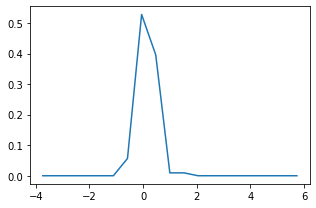

In [25]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
freqs, bins = np.histogram(traj_PC1, bins=bins_PC1)
freqs = freqs/freqs.sum()
x = (bins[:-1] + bins[1:])/2
plt.plot(x, freqs)
plt.xlabel("")
plt.ylabel("")
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()


<Figure size 432x288 with 0 Axes>

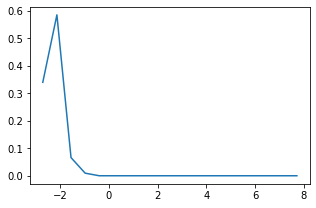

In [26]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
freqs, bins = np.histogram(traj_PC2, bins=bins_PC2)
freqs = freqs/freqs.sum()
x = (bins[:-1] + bins[1:])/2
plt.plot(x, freqs)
plt.xlabel("")
plt.ylabel("")
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()


<Figure size 432x288 with 0 Axes>

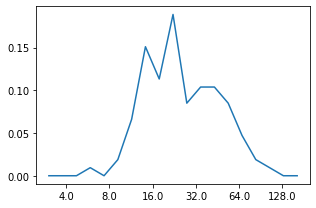

In [28]:
plt.clf()
f = plt.figure(figsize=(4.5, 3))
freqs, bins = np.histogram(list(traj_speed.values()), bins=bins_speed)
freqs = freqs/freqs.sum()
x = (bins[:-1] + bins[1:])/2
plt.plot(x, freqs)
plt.xlabel("")
plt.ylabel("")
plt.grid(b=False, which='major', axis='x')
speed_ticks = [4., 8., 16., 32., 64., 128.]
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks)
plt.tight_layout()